In [1]:
%matplotlib inline

In [2]:
def warn(*args, **kwargs):
    pass
import warnings,seaborn
warnings.warn = warn
warnings.filterwarnings("ignore")
from seaborn import distplot


In [33]:
from numpy import load,save, where,sort,array,append, hstack,mean,array_equal,argsort,std as std_deviation
from operator import itemgetter as item
import pandas as pd
import numpy
import pickle
import os.path
from operator import itemgetter
from utility import *
import seaborn as sns
from seaborn import distplot
from random import randint
from sklearn.utils import shuffle
from math import sqrt,log10,floor
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdchem import ResonanceMolSupplier as resonanceMol
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from scipy.stats import ttest_ind as TTest

In [4]:
def return_true(self, other):
    return True
Chem.Mol.__eq__ = return_true

In [5]:
data = pd.read_csv('allFunctionals.csv','|')
molsCsv = []
for SMILE in data['Unnamed: 1'][1:]:
    molsCsv += [Chem.MolFromSmiles(SMILE)]
HOMOCsv = []
for item in data['B3LYP'][1:]:
    HOMOCsv += [float(item)]
datFileID = []
for item in data['Unnamed: 0'][1:]:
    datFileID += [int(item)]

In [6]:
def loadNumpy(name,path='.'):
    if ".npy" in name:
        fullPath = path+'/'+name
    else:
        fullPath = path+'/'+name+'.npy'
    return load(fullPath)

def saveNumpy(obj, name, path='.'):
    if ".npy" not in name:
        fullPath = path+'/'+name
        save(fullPath, obj)
        print name,'saved successfully in',path
    else:
        fullPath = path+'/'+name.split(".npy")[0]
        save(fullPath, obj)
        print name,'saved successfully in',path
        

In [7]:
def crossVal_Diff_Arrange(Type,mols,estimator):
    y = HOMO
    if Type=='maccs':
        X = maccs
    elif Type == 'atompair':
        X = atom
    
    for i in range(2):
        X,y,mols = shuffle(X,y,mols)
    
    predicted, predictedRepeat = [],[]
    for i in range(3):
        predictedRepeat += [cross_val_predict(estimator, X, y, cv=5)]

    for i in range(len(X)):
        predicted += [(predictedRepeat[0][i]+predictedRepeat[1][i]+predictedRepeat[2][i])/3]

    All = []
    for i in range(len(X)):
        All += [[abs(y[i]-predicted[i])]+[predicted[i]]+[y[i]]+X[i].tolist()]
        
    AllSorted,molsSorted = [list(x) for x in zip(*sorted(zip(All, mols), key=itemgetter(0)))]
    diff, actualY, predictedY, actualX = [],[],[],[]
    for i in range(len(X)):
        diff += [AllSorted[i][0]]
        predictedY += [AllSorted[i][1]]
        actualY += [AllSorted[i][2]]
        actualX += [AllSorted[i][3:]]
        
#     testMol = molsSorted[0]
#     molsAdjusted = []
#     predictedAdjusted,actualAdjusted = [],[]
#     actualXAdjusted = []
#     diffAdjusted = []
    
#     for mol in molsSorted:
#         index = returnLocationInCsv(mol)
#         molsAdjusted += [molsSorted[index]]
#         diffAdjusted += [diff[index]]
#         actualAdjusted += [actualY[index]]
#         predictedAdjusted += [predictedY[index]]
#         actualXAdjusted += [actualX[index]]
        
        
#     return diffAdjusted, predictedAdjusted, actualAdjusted, actualXAdjusted, molsAdjusted
    return diff, predictedY, actualY, actualX, molsSorted

In [9]:
def trainTest_Diff(Type,mols,estimator):
    y = HOMOTrain80
    if Type=='maccs':
        X = maccsTrain80
    elif Type == 'atompair':
        X = atomTrain80
    
    for i in range(2):
        X,y,mols = shuffle(X,y,mols)
    
    predicted, predictedRepeat = [],[]
    for i in range(3):
        predictedRepeat += [cross_val_predict(estimator, X, y, cv=5)]

    for i in range(len(X)):
        predicted += [(predictedRepeat[0][i]+predictedRepeat[1][i]+predictedRepeat[2][i])/3]

    All = []
    for i in range(len(X)):
        All += [[abs(y[i]-predicted[i])]+[predicted[i]]+[y[i]]+X[i].tolist()]
        
    AllSorted,molsSorted = [list(x) for x in zip(*sorted(zip(All, mols), key=item(0)))]
    diff, actualY, predictedY, actualX = [],[],[],[]
    for i in range(len(X)):
        diff += [AllSorted[i][0]]
        predictedY += [AllSorted[i][1]]
        actualY += [AllSorted[i][2]]
        actualX += [AllSorted[i][3:]]
        
        
    return diff, predictedY, actualY, actualX, molsSorted

In [10]:
def extractMonomerHOMO():
    data = open('HOPV_15.data').readlines()
    lineNums = []
    for i in range(len(data)):
        if 'InChI' in data[i]:
            lineNums += [i-5]
    endLineNums = []
    for lineNum in lineNums[1:]:
        endLineNums += [lineNum]

    endLineNums += [len(data)-1]

    count = 0
    DFT = []
    molecule = []
    for i in range(len(data)):
        if i == endLineNums[count]+1 or i ==len(data)-1:
            DFT += [molecule]
            count += 1
            molecule = []
        if 'B3LYP' in data[i]:
            molecule += [float(data[i].split('DFT,')[1].split(',')[0])]
    
    count =0
    adjustedMonomer = []
    for i in range(350):
        if i == datFileID[count]-1:
            adjustedMonomer += [DFT[i]]
            count +=1
            
        
    return adjustedMonomer

def returnLocationInCsv(testMol):
    testFP = FingerprintMols.FingerprintMol(testMol)
    for i in range(len(molsCsv)):
        mol = molsCsv[i]
        fp = FingerprintMols.FingerprintMol(mol)
        if DataStructs.FingerprintSimilarity(fp, testFP) == 1:
            return i

In [11]:
HOMO = loadNumpy('HOMO')
atom = loadNumpy('AtomPairCount')
topo = loadNumpy('TopologicalCount')
morgan = loadNumpy('MorganCount')
maccs = loadNumpy('maccsCount')
mols = loadNumpy('mols')

#### sorting by argsort

In [39]:
sortedIndices = argsort(HOMO)

HOMOSorted = []
atomSorted = []
topoSorted = []
morganSorted = []
maccsSorted = []
molsSorted = []

for i in sortedIndices:
    HOMOSorted += [HOMO[i]]
    atomSorted += [atom[i]]
    topoSorted += [topo[i]]
    morganSorted += [morgan[i]]
    maccsSorted += [maccs[i]]
    molsSorted += [mols[i]]

In [40]:
saveNumpy(HOMOSorted,'HOMOSorted')
saveNumpy(atomSorted,'atomSorted')
saveNumpy(topoSorted,'topoSorted')
saveNumpy(morganSorted,'morganSorted')
saveNumpy(maccsSorted,'maccsSorted')
saveNumpy(molsSorted,'molsSorted')

HOMOSorted saved successfully in .
atomSorted saved successfully in .
topoSorted saved successfully in .
morganSorted saved successfully in .
maccsSorted saved successfully in .
molsSorted saved successfully in .


In [12]:
trainIndices, testIndices = loadNumpy('trainIndices'), loadNumpy('testIndices')

In [10]:
HOMOTrain80 = loadNumpy('trainHOMO80')
atomTrain80= loadNumpy('trainAtom80')
topoTrain80= loadNumpy('trainTopo80')
morganTrain80= loadNumpy('trainMorgan80')
maccsTrain80= loadNumpy('trainMaccs80')
molsTrain80= loadNumpy('trainMols80')

In [13]:
atom80 = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=0.33, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

maccs80 = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=25,
          max_features=0.33, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

### Best and Worst Molecules

In [11]:
worstMols,bestMols = molsSorted[:5], molsSorted[-5:]
worstAtom, bestAtom = atomSorted[:5], atomSorted[-5:]
worstMaccs, bestMaccs = maccsSorted[:5], maccsSorted[-5:]
worstMorgan, bestMorgan = morganSorted[:5], morganSorted[-5:]
worstTopo, bestTopo = topoSorted[:5], topoSorted[-5:]

### There is not much difference in the level of conjugation (number of conjugated bonds)

#### Best

In [21]:
for i in range(-10,0):
    mol = molsSorted[i]
    print resonanceMol(mol).GetNumConjGrps(), HOMOSorted[i]

1 -0.174133
1 -0.174056
1 -0.174
1 -0.173929
1 -0.173889
1 -0.173267
1 -0.171118
1 -0.17075
4 -0.167
1 -0.164667


#### Worst

In [22]:
for i in range(0,10):
    mol = molsSorted[i]
    print resonanceMol(mol).GetNumConjGrps(), HOMOSorted[i]

1 -0.24375
1 -0.239
1 -0.238
1 -0.237211
1 -0.234125
1 -0.232
2 -0.230429
1 -0.23
1 -0.22825
1 -0.222


## Conjugation for the best and worst predicted (again no difference based on conjugation)

In [14]:
diff_atom, predictedHOMO_atom, actualHOMO_atom, actual_atom,mols_atom = crossVal_Diff_Arrange('atompair',mols,atom80)

In [15]:
diff_maccs, predictedHOMO_maccs, actualHOMO_maccs, actual_maccs,mols_maccs = crossVal_Diff_Arrange('maccs',mols, maccs80)

In [16]:
NUM = 20
worstPredictAtom, bestPredictAtom = actual_atom[-NUM:], actual_atom[:NUM]
worstPredictMaccs, bestPredictMaccs = actual_maccs[-NUM:], actual_maccs[:NUM]

worstMols_Atom, bestMols_Atom = mols_atom[-NUM:], mols_atom[:NUM]
worstMols_Maccs, bestMols_Maccs = mols_maccs[-NUM:], mols_maccs[:NUM]

### Best Predicted

In [70]:
for i in range(0,10):
    mol = mols_atom[i]
    print resonanceMol(mol).GetNumConjGrps(), actualHOMO_atom[i], predictedHOMO_atom[i]

1 -0.184462 -0.184475733472
2 -0.187889 -0.187921427048
1 -0.192 -0.191939656694
1 -0.199063 -0.198991715556
1 -0.186 -0.186075663972
2 -0.189071 -0.188987045375
1 -0.2 -0.200088690889
1 -0.188462 -0.188552785433
1 -0.192421 -0.192520972167
1 -0.184389 -0.184275054139


### Worst Predicted

In [18]:
for i in range(-1,-11,-1):
    mol = mols_atom[i]
    print resonanceMol(mol).GetNumConjGrps(), actualHOMO_atom[i], predictedHOMO_atom[i]

1 -0.237211 -0.199166737778
1 -0.234125 -0.198197342556
2 -0.230429 -0.203220642694
4 -0.167 -0.18965383571
1 -0.212077 -0.1911161545
1 -0.201 -0.220816817778
1 -0.24375 -0.224078131667
1 -0.239 -0.219399233333
1 -0.222 -0.203169153889
1 -0.22825 -0.209478674028


### Find the distribution for the ones which are predicted well or not 

In [19]:
monomerHOMO = extractMonomerHOMO()

#### Worst Predicted Distribution

In [38]:
worstOrgIndicesAtom = []
for i in range(-1,-21,-1):
    worstOrgIndicesAtom += [returnLocationInCsv(mols_atom[i])]

In [39]:
bestOrgIndicesAtom = []
for i in range(20):
    bestOrgIndicesAtom += [returnLocationInCsv(mols_atom[i])]

In [40]:
worstOrgIndicesMaccs = []
for i in range(-1,-21,-1):
    worstOrgIndicesMaccs += [returnLocationInCsv(mols_maccs[i])]

In [41]:
bestOrgIndicesMaccs = []
for i in range(20):
    bestOrgIndicesMaccs += [returnLocationInCsv(mols_maccs[i])]

In [24]:
saveNumpy(worstOrgIndicesAtom,'worstOrgIndicesAtom')
saveNumpy(worstOrgIndicesMaccs,'worstOrgIndicesMaccs')
saveNumpy(bestOrgIndicesAtom,'bestOrgIndicesAtom')
saveNumpy(bestOrgIndicesMaccs,'bestOrgIndicesMaccs')

worstOrgIndicesAtom saved successfully in .
worstOrgIndicesMaccs saved successfully in .
bestOrgIndicesAtom saved successfully in .
bestOrgIndicesMaccs saved successfully in .


In [111]:
for i in bestOrgIndicesAtom:
    print len(monomerHOMO[i]),mean(monomerHOMO[i]),std(monomerHOMO[i])

13 -0.184461538462 0.000498518515262
9 -0.187888888889 0.000314269680527
18 -0.192 2.77555756156e-17
16 -0.1990625 0.000242061459138
16 -0.186 0.000612372435696
14 -0.189071428571 0.000257539376819
2 -0.2 0.001
13 -0.188461538462 0.00230769230769
19 -0.192421052632 0.00311728271473
18 -0.184388888889 0.000825892708184


In [112]:
for i in worstOrgIndicesAtom:
    print len(monomerHOMO[i]),mean(monomerHOMO[i]),std(monomerHOMO[i])

17 -0.167 0.0
4 -0.22825 0.000829156197589
1 -0.232 0.0
4 -0.201 0.001
4 -0.24375 0.00178535710714
13 -0.212076923077 0.0015423028966
16 -0.222 0.0
3 -0.178 2.77555756156e-17
8 -0.196625 0.000484122918276
18 -0.198888888889 0.000458122847291


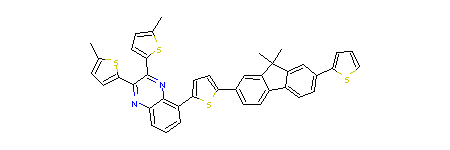

In [140]:
molsCsv[280]

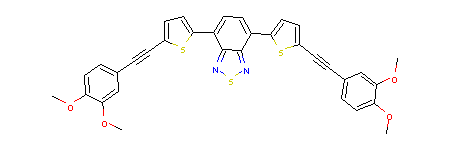

In [113]:
molsCsv[281]

In [146]:
Max = 0
for HOMO in HOMOCsv:
    if len(str(HOMO))-3>Max:
        Max = len(str(HOMO))-3

In [155]:
count = 0
for HOMO in HOMOCsv:
    for homo in avgHOMO:
        if homo == HOMO:
            count += 1

In [98]:
worstOrgIndicesAtom

{-10: 241,
 -9: 222,
 -8: 20,
 -7: 143,
 -6: 189,
 -5: 213,
 -4: 89,
 -3: 218,
 -2: 53,
 -1: 122}

In [100]:
for i in range(20):
    print len(monomerHOMO[i])

18
8
18
15
16
12
10
15
11
9
15
12
1
15
18
18
19
6
13
20


In [177]:
avgHOMO = []
for i in range(len(monomerHOMO)):
    avg = mean(monomerHOMO[i])
    avgHOMO += [float("{:.6f}".format(avg))]

### <font color="blue"> Evaluate if the standard deviation of both are statistically significant </font>

In [34]:
std_deviation(monomerHOMO[bestOrgIndicesAtom[0]])

0.00088167099872911848

#### <font color="red"> T Test on standard deviation for monomers for best and worst predicted (Atom Pair) </font>

In [44]:
bestStd,worstStd = [],[]
bestMean, worstMean = [],[]
numBest, numWorst = [],[]
for i in range(20):
    bestStd += [std_deviation(monomerHOMO[bestOrgIndicesAtom[i]])]
    bestMean += [mean(monomerHOMO[bestOrgIndicesAtom[i]])]
    numBest += [len(monomerHOMO[bestOrgIndicesAtom[i]])]
    
    worstStd += [std_deviation(monomerHOMO[worstOrgIndicesAtom[i]])]
    worstMean += [mean(monomerHOMO[worstOrgIndicesAtom[i]])]
    numWorst += [len(monomerHOMO[worstOrgIndicesAtom[i]])]

In [43]:
TTest(bestStd,worstStd)

Ttest_indResult(statistic=1.4703504705411439, pvalue=0.14969914654521016)

In [45]:
TTest(bestMean,worstMean)

Ttest_indResult(statistic=3.3527849947586734, pvalue=0.0018211963319228425)

In [46]:
TTest(numBest,numWorst)

Ttest_indResult(statistic=3.8601371526163999, pvalue=0.00042663720581077462)

#### <font color="green"> T Test on standard deviation for monomers for best and worst predicted (Maccs) </font>

In [48]:
bestStd,worstStd = [],[]
bestMean, worstMean = [],[]
numBest, numWorst = [],[]
for i in range(20):
    bestStd += [std_deviation(monomerHOMO[bestOrgIndicesMaccs[i]])]
    bestMean += [mean(monomerHOMO[bestOrgIndicesMaccs[i]])]
    numBest += [len(monomerHOMO[bestOrgIndicesMaccs[i]])]
    
    worstStd += [std_deviation(monomerHOMO[worstOrgIndicesMaccs[i]])]
    worstMean += [mean(monomerHOMO[worstOrgIndicesMaccs[i]])]
    numWorst += [len(monomerHOMO[worstOrgIndicesMaccs[i]])]

In [49]:
TTest(bestStd,worstStd)

Ttest_indResult(statistic=-1.7156346853481124, pvalue=0.094373139898495884)

In [50]:
TTest(bestMean,worstMean)

Ttest_indResult(statistic=3.5199980314714909, pvalue=0.0011386786215529909)

In [51]:
TTest(numBest,numWorst)

Ttest_indResult(statistic=2.4704671124630062, pvalue=0.018095206117606469)

### <font color="purple"> Investigating individual monomer distributions </font>

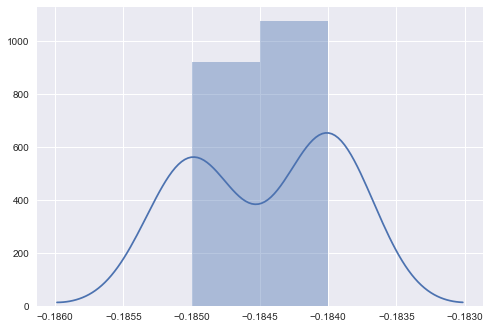

In [94]:
distplot(monomerHOMO[bestOrgIndicesAtom[0]])

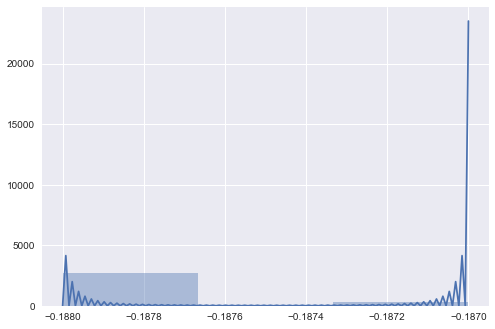

In [93]:
distplot(monomerHOMO[bestOrgIndicesAtom[1]])

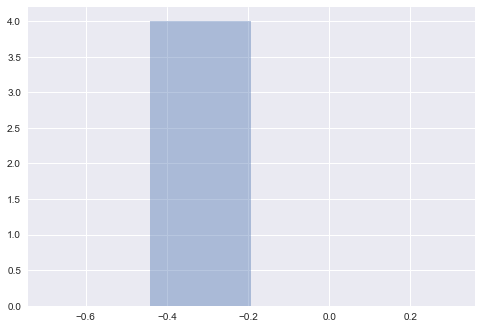

In [95]:
distplot(monomerHOMO[bestOrgIndicesAtom[2]])

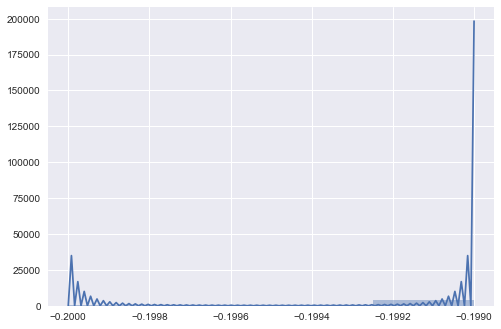

In [96]:
distplot(monomerHOMO[bestOrgIndicesAtom[3]])

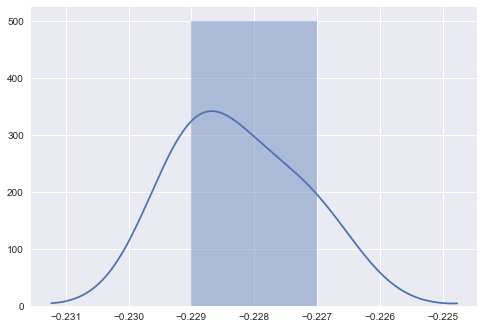

In [83]:
distplot(monomerHOMO[worstOrgIndicesAtom[-2]])

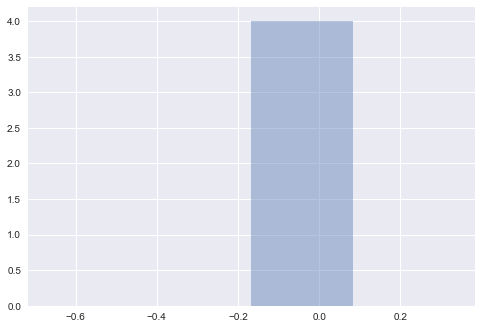

In [78]:
distplot(monomerHOMO[worstOrgIndicesAtom[-1]])

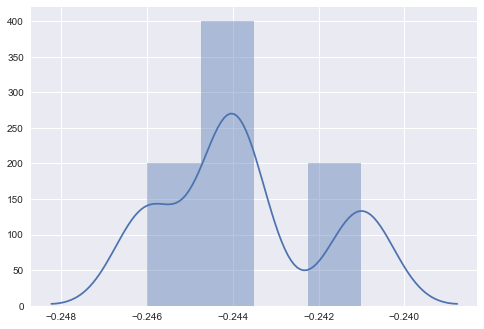

In [86]:
distplot(monomerHOMO[worstOrgIndicesAtom[-5]])

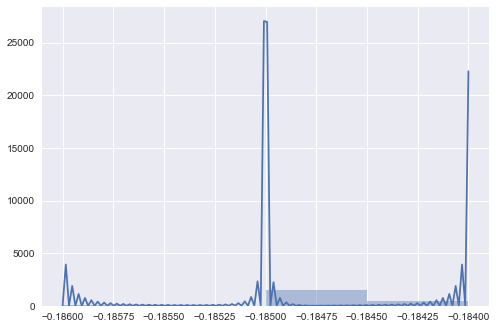

In [74]:
distplot(monomerHOMO[worstOrgIndices[2]])

In [75]:
bestOrgIndices = []
for i in range(10):
    bestOrgIndices += [returnLocationInCsv(mols_atom[i])]